In [1]:
import my_package.rectification as rectification
msi_file="/home/llx/project/MSI_data/sma/V11L12-038/V11L12-038_D1/output_data/V11L12-038_D1_MSI/V11L12-038_Mouse_D1.Visium.9aa.220826_smamsi.csv"
st_path="/home/llx/project/MSI_data/sma/V11L12-038/V11L12-038_D1/output_data/V11L12-038_D1_RNA/outs/"
msi_path="/home/llx/project/MSI_data/sma/V11L12-038/V11L12-038_D1/output_data/V11L12-038_D1_MSI/"
import importlib
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import cv2

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# seed_everything()
seed=2025
rectification.fix_seed(seed)

67 74


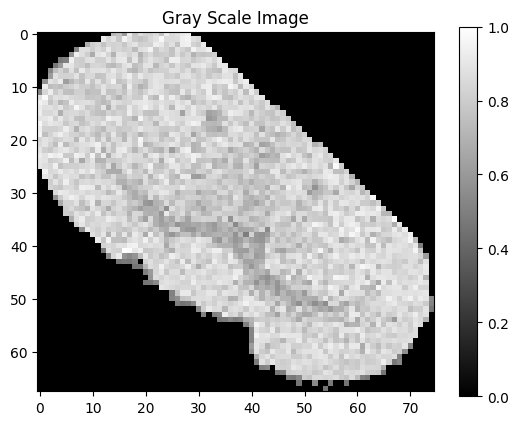

In [3]:
ms_org=pd.read_csv(msi_file)
ms_sp=ms_org.copy()
print(np.max(ms_sp.loc[:,"x"]),np.max(ms_sp.loc[:,"y"]))
ms=rectification.msi_sum(ms_sp,0.45)#0.6
rectification.tensor_viewer(ms)

In [4]:
org_size=ms.shape

In [5]:
org_size

(68, 75)

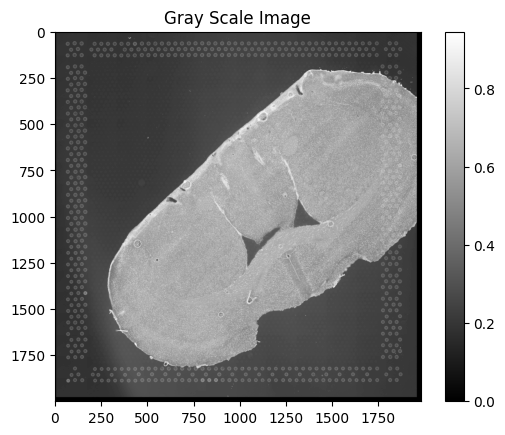

In [6]:
image_path = '/home/llx/project/MSI_data/sma/V11L12-038/V11L12-038_D1/output_data/V11L12-038_D1_RNA/outs/spatial/tissue_hires_image.png'

normalized_gray_image=rectification.he_img(image_path)
rectification.tensor_viewer(normalized_gray_image)


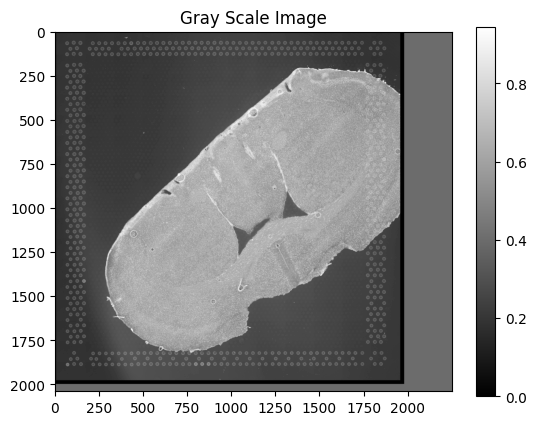

In [7]:
HE_tensor,msi_tensor,rate=rectification.he_padding(ms,normalized_gray_image,0.4)#填充到与MSI等比例
rectification.tensor_viewer(HE_tensor)

In [8]:
target_size=np.array(HE_tensor.shape[2:4])
target_size

array([2040, 2250])

In [9]:
device=torch.device("cuda")

In [10]:
fit_af=rectification.fit(device=device,num_epochs=1000)
fit_af.train_AF(msi_tensor,HE_tensor,list(target_size))#训练

  0%|                                            | 0/1000 [00:00<?, ?it/s]/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|████████████████████████████████| 1000/1000 [00:02<00:00, 433.53it/s]


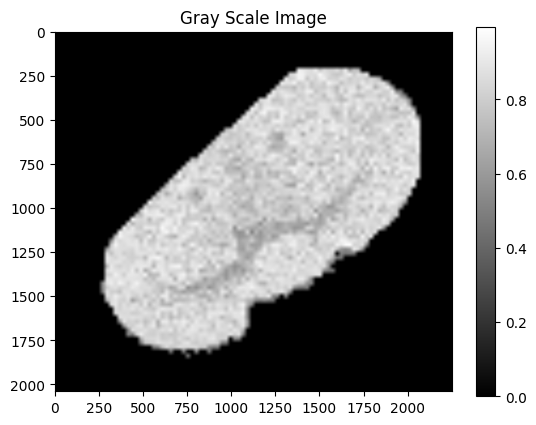

torch.Size([1, 1, 2040, 2250])


In [11]:
af_msi=fit_af.net(msi_tensor.to(device))
rectification.tensor_viewer(af_msi.cpu().detach())
print(af_msi.shape)

In [12]:
af_theta=fit_af.net.theta.squeeze().cpu().detach()
print(af_theta)

tensor([[-1.2423,  0.0000,  0.0433],
        [ 0.0000,  1.2423, -0.0134]])


In [13]:
def torch_af_transfor(af_theta,shape,org_shape,points):

    H, W=org_shape

    points_norm = torch.stack([
        (points[:, 0] / W)*2-1,
        (points[:, 1] / H)*2-1], dim=0).T
    #补齐af
    line3=torch.tensor([[0,0,1]],dtype=torch.float32)
    al_3=torch.cat([af_theta,line3],dim=0)
    af_norm=torch.inverse(al_3)
    #补齐点
    ones=torch.ones(points_norm.shape[0],1)
    points_norm=torch.cat([points_norm,ones],dim=1)
    points_norm=points_norm.T
    print(points_norm.shape)
    print(af_norm.shape)
    points_norm=torch.mm(af_norm,points_norm).T

    print(points_norm)
    H_prime, W_prime = shape

    transformed_points = torch.stack([
        (points_norm[:, 0]+1)/2 * W_prime,
        (points_norm[:, 1]+1)/2 * H_prime
    ], dim=0)

    return transformed_points.T

In [14]:
ms_org_x_y = torch.tensor(np.array(ms_sp.loc[:,["y","x"]]),dtype=torch.float32)

ms_he = torch_af_transfor(af_theta,target_size,org_size,ms_org_x_y)

ms_he

torch.Size([3, 5100])
torch.Size([3, 3])
tensor([[ 0.8398, -0.7942,  1.0000],
        [ 0.8184, -0.7942,  1.0000],
        [ 0.7969, -0.7942,  1.0000],
        ...,
        [-0.7057,  0.7921,  1.0000],
        [-0.7272,  0.7921,  1.0000],
        [-0.7486,  0.7921,  1.0000]])


tensor([[2069.8289,  209.9246],
        [2045.6796,  209.9246],
        [2021.5302,  209.9246],
        ...,
        [ 331.0710, 1827.9354],
        [ 306.9216, 1827.9354],
        [ 282.7722, 1827.9354]])

In [15]:
ms_sp

,x,y,108.901945,108.902095,109.02966,109.07286,109.07340500000001,110.89903000000001,110.89917,111.25453999999999,...,986.24171,986.4706249999999,987.4723799999999,987.49128,995.914325,995.954135,995.99258,997.749015,997.881305,999.95018
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095,67,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5096,67,71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5097,67,72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5098,67,73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


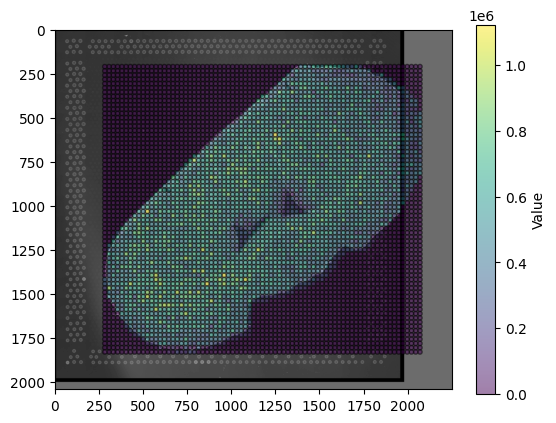

In [16]:
ms_sp.loc[:,["he_x","he_y"]]=ms_he.numpy()
plt.imshow(HE_tensor.squeeze().detach().cpu(), cmap='gray')
scatter = plt.scatter(ms_sp['he_x'], 
                    ms_sp['he_y'], 
                    c=ms_sp['108.901945'], 
                    cmap='viridis', 
                    s=10,
                    alpha=0.5,
                    edgecolor='k')

plt.colorbar(scatter, label='Value')

In [17]:
import SM2ST
ms_adata = SM2ST.ms2anndata(ms_org = ms_org,ms_sp = ms_sp,HE_path = image_path,in_tissue=True)

In [18]:
import scanpy as sc
st_adata=sc.read_visium(st_path,
               count_file='filtered_feature_bc_matrix.h5',
               source_image_path="tissue_hires_image.png")
st_adata

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2913 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [19]:
st_adata.uns['spatial']['V11L12-038_D1']['scalefactors']['tissue_hires_scalef']

0.04155585

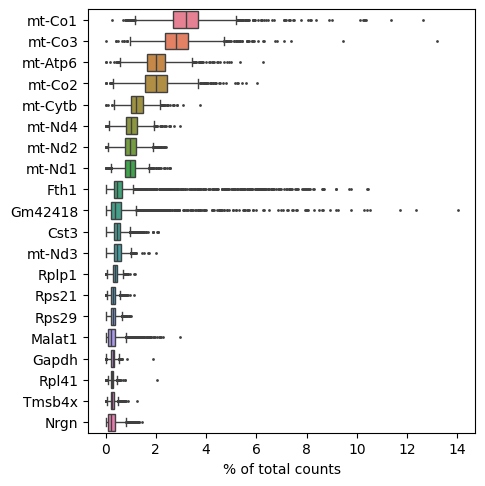

In [20]:
sc.pl.highest_expr_genes(st_adata, n_top=20, )

In [21]:
st_adata.uns['spatial']['V11L12-038_D1']['scalefactors']['tissue_lowres_scalef']/st_adata.uns['spatial']['V11L12-038_D1']['scalefactors']['tissue_hires_scalef']

0.30000002406400067

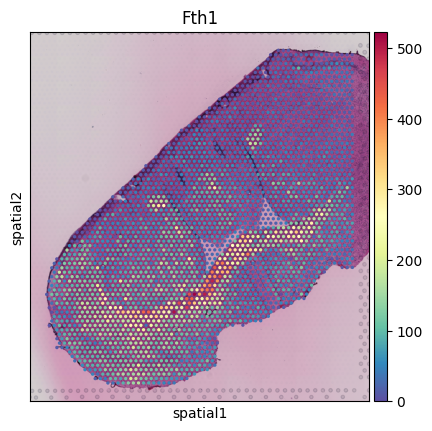

In [22]:
sc.pl.spatial(st_adata, 
              img_key="hires", 
              color=['Fth1'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=1,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

In [23]:
st_adata.X.A

array([[0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 3.]], dtype=float32)

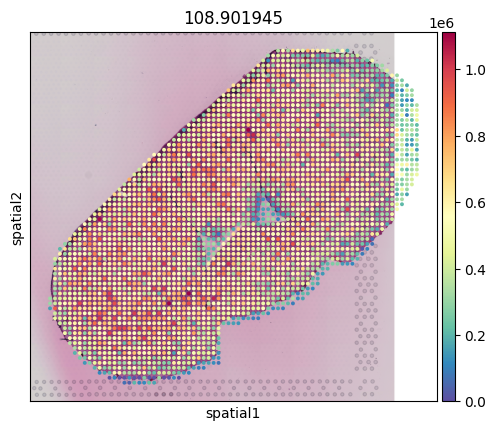

In [24]:
sc.pl.spatial(ms_adata, 
              img_key="hires", 
              color=['108.901945'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

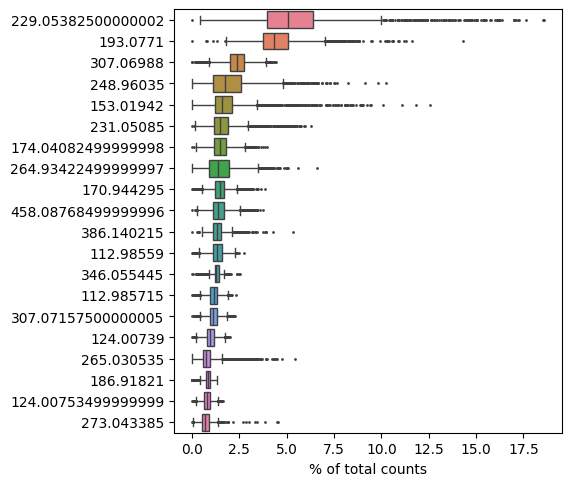

In [25]:
sc.pl.highest_expr_genes(ms_adata, n_top=20, )

In [26]:
from scipy.sparse import csr_matrix
st_intensity = csr_matrix(st_adata.X.A, dtype=np.float32)
print(st_intensity.shape)
st_adata1 = ad.AnnData(st_intensity)
st_adata1.var_names=st_adata.var_names
st_adata1.obs_names=st_adata.obs_names
st_adata1.obs["array_row"]=st_adata.obs["array_row"]##raw x
st_adata1.obs["array_col"]=st_adata.obs["array_col"]##raw y
st_adata1.obsm["spatial"]=st_adata.obsm["spatial"]*st_adata.uns['spatial']['V11L12-038_D1']['scalefactors']['tissue_hires_scalef']
from PIL import Image
image_path = '/home/llx/project/MSI_data/sma/V11L12-038/V11L12-038_D1/output_data/V11L12-038_D1_RNA/outs/spatial/tissue_hires_image.png'
image = Image.open(image_path)
image_array = np.array(image)
spatial_key = "spatial"
library_id = "tV11L12-038_A1_c"  # 你可以自定义这个 ID
st_adata1.uns[spatial_key] = {library_id: {}}
st_adata1.uns[spatial_key][library_id]["images"] = {"hires": image_array}
st_adata1.uns[spatial_key][library_id]["scalefactors"] = {
    "tissue_hires_scalef": 1,  # 图像像素和空间坐标的比例因子H_pnnrime
    "spot_diameterres_full": 0.5,  # 每个观测点的直径
    'fiducial_diameter_fullres': 609.8565193216596,
    'spot_diameter_fullres': 377.5302262467417
}

(2913, 32285)


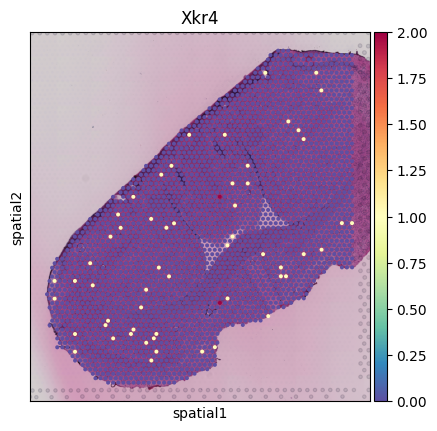

In [27]:
sc.pl.spatial(st_adata1, 
              img_key="hires", 
              color=['Xkr4'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

In [28]:
st_adata1.obsm['spatial']

array([[1433.2612665 , 1218.79152465],
       [ 431.4328347 , 1409.03420595],
       [1335.81279825,  462.64127805],
       ...,
       [ 564.2453313 , 1429.8536868 ],
       [ 527.6761833 , 1114.81878795],
       [ 697.34871885, 1702.83406545]])

In [29]:
ms_adata.obsm['spatial'].shape

(3084, 2)

In [30]:
ms_adata.uns['coord'] = st_adata1.obsm['spatial']

<Axes: title={'center': '108.901945'}, xlabel='spatial1', ylabel='spatial2'>

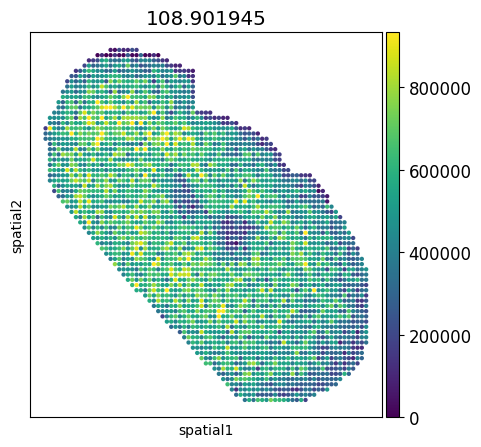

In [31]:
plot_gene = '108.901945'#
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(ms_adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

In [32]:
# sc.pp.normalize_total(ms_adata, target_sum=1e3)
sc.pp.normalize_total(ms_adata, target_sum=1e4)
sc.pp.log1p(ms_adata)

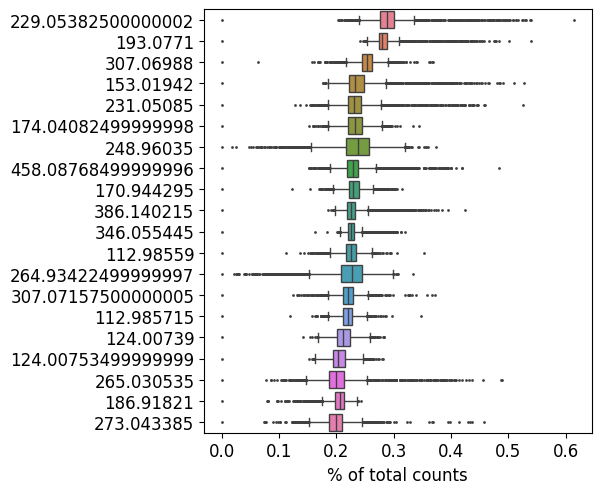

In [33]:
sc.pl.highest_expr_genes(ms_adata, n_top=20, )

<Axes: title={'center': '108.901945'}, xlabel='spatial1', ylabel='spatial2'>

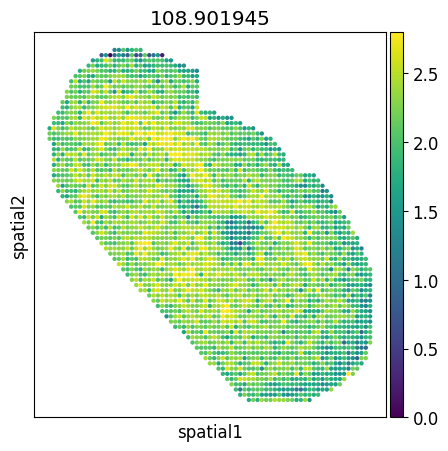

In [34]:
plot_gene = '108.901945'#
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(ms_adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

In [35]:
import SM2ST as SM2ST
adata_SMLED = SM2ST.train_SMLED(adata=ms_adata, mask_ratio=0., coord_sf=2.0, train_epoch=10000, experiment='generation', WMMSE=1.)

Size of Input:  (3084, 3658)
282.77215576171875 209.92457580566406
pixel_step: 48.287897699999576
              0          1
0     31.006795   1.000000
1     30.506681   1.000000
2     30.006568   1.000000
3     29.506453   1.000000
4     29.006342   1.000000
...         ...        ...
3079  10.502152  34.507585
3080  10.002038  34.507585
3081   9.501925  34.507585
3082   9.001812  34.507585
3083   8.501699  34.507585

[3084 rows x 2 columns]               0          1
0     24.825620  21.892749
1      4.078632  25.832509
2     22.807548   6.233541
3     10.085517  31.915985
4     28.552815   1.441803
...         ...        ...
2908  18.565723  13.634574
2909   9.828202  25.390168
2910   6.829063  26.263662
2911   6.071748  19.739565
2912   9.585517  31.916846

[2913 rows x 2 columns]


Epochs: 100%|█| 10000/10000 [9:29:14<00:00,  3.42s/it, loss_re: 0.07620, l


<Axes: title={'center': '108.901945'}, xlabel='spatial1', ylabel='spatial2'>

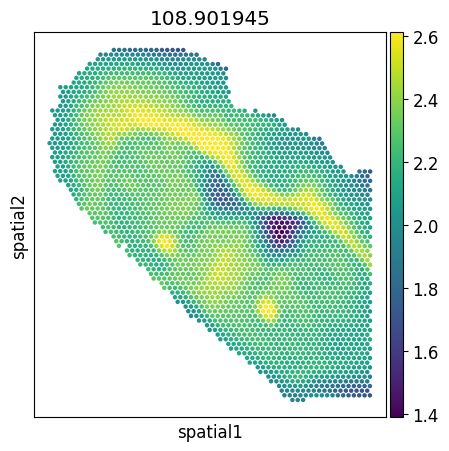

In [36]:
plot_gene = '108.901945'#
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(adata_SMLED, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

In [37]:
from PIL import Image
image_path = '/home/llx/project/MSI_data/sma/V11L12-038/V11L12-038_D1/output_data/V11L12-038_D1_RNA/outs/spatial/tissue_hires_image.png'
image = Image.open(image_path)
image_array = np.array(image)
spatial_key = "spatial"
library_id = "tV11L12-038_A1_c"  # 你可以自定义这个 ID
adata_SMLED.uns[spatial_key] = {library_id: {}}
adata_SMLED.uns[spatial_key][library_id]["images"] = {"hires": image_array}
adata_SMLED.uns[spatial_key][library_id]["scalefactors"] = {
    "tissue_hires_scalef": 1,  # 图像像素和空间坐标的比例因子
    "spot_diameterres_full": 0.5,  # 每个观测点的直径
    'fiducial_diameter_fullres': 609.8565193216596,
    'spot_diameter_fullres': 377.5302262467417
}

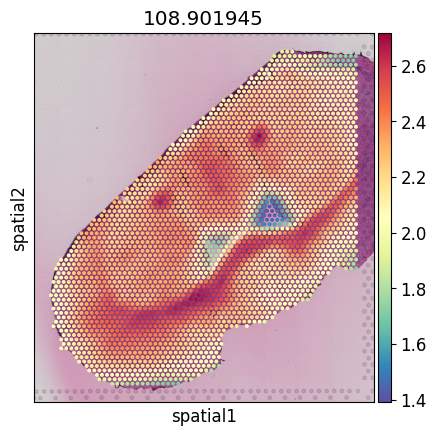

In [38]:
sc.pl.spatial(adata_SMLED, 
              img_key="hires", 
              color=['108.901945'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

In [55]:
# adata_SMLED.write_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_SMLED_test_22.h5ad')

In [40]:
# adata_SMLED = sc.read_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/adata_SMLED_test_22.h5ad')

In [41]:
from PIL import Image
image_path = '/home/llx/project/MSI_data/sma/V11L12-038/V11L12-038_D1/output_data/V11L12-038_D1_RNA/outs/spatial/tissue_hires_image.png'
image = Image.open(image_path)
image_array = np.array(image)
spatial_key = "spatial"
library_id = "V11L12-038_D1"  # 你可以自定义这个 ID152.055573563462
adata_SMLED.uns[spatial_key] = {library_id: {}}
adata_SMLED.uns[spatial_key][library_id]["images"] = {"hires": image_array}
adata_SMLED.uns[spatial_key][library_id]["scalefactors"] = {
    "tissue_hires_scalef": 1,  # 图像像素和空间坐标的比例因子
    "spot_diameterres_full": 0.5,  # 每个观测点的直径
    'fiducial_diameter_fullres': 609.8565193216596,
    'spot_diameter_fullres': 377.5302262467417
}

In [42]:
import squidpy as sq
sq.gr.spatial_neighbors(adata_SMLED)
sq.gr.spatial_autocorr(adata_SMLED, mode="moran", genes=adata_SMLED.var_names)
sq.gr.spatial_autocorr(adata_SMLED, mode="geary", genes=adata_SMLED.var_names)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning: 376 variables were constant, will return nan for these.
  warnings.warn(
/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/scanpy/metrics/_gearys_c.py:295: UserWarning: 376 variables were constant, will return nan for these.
  warnings.warn(


In [43]:
sq.gr.spatial_neighbors(ms_adata)
sq.gr.spatial_autocorr(ms_adata, mode="moran", genes=ms_adata.var_names)
sq.gr.spatial_autocorr(ms_adata, mode="geary", genes=ms_adata.var_names)

In [44]:
ms_adata_high_moran_genes = ms_adata.uns['moranI']['I'][(ms_adata.uns['moranI']['I'] > 0.5) & (ms_adata.uns['moranI']['pval_norm'] < 0.05)].index.tolist()
ms_adata_high_moran = ms_adata[:, ms_adata_high_moran_genes]

ms_adata_high_geary_genes = ms_adata.uns['gearyC']['C'][(ms_adata.uns['gearyC']['C'] < 0.5) & (ms_adata.uns['gearyC']['pval_norm'] < 0.05)].index.tolist()
ms_adata_high_geary = ms_adata[:, ms_adata_high_geary_genes]

In [45]:
adata_SMLED_high_moran_genes = adata_SMLED.uns['moranI']['I'][(adata_SMLED.uns['moranI']['I'] > 0.5) & (adata_SMLED.uns['moranI']['pval_norm'] < 0.05)].index.tolist()
adata_SMLED_high_moran = adata_SMLED[:, adata_SMLED_high_moran_genes]

adata_SMLED_high_geary_genes = adata_SMLED.uns['gearyC']['C'][(adata_SMLED.uns['gearyC']['C'] < 0.5) & (adata_SMLED.uns['gearyC']['pval_norm'] < 0.05)].index.tolist()
adata_SMLED_high_geary = adata_SMLED[:, adata_SMLED_high_geary_genes]

In [46]:
ms_adata_set1 = set(ms_adata_high_geary.var_names)
ms_adata_set2 = set(ms_adata_high_moran.var_names)
ms_adata_v = ms_adata_set1&ms_adata_set2

In [47]:
adata_SMLED_set1 = set(adata_SMLED_high_geary.var_names)
adata_SMLED_set2 = set(adata_SMLED_high_moran.var_names)
adata_SMLED_v = adata_SMLED_set1&adata_SMLED_set2

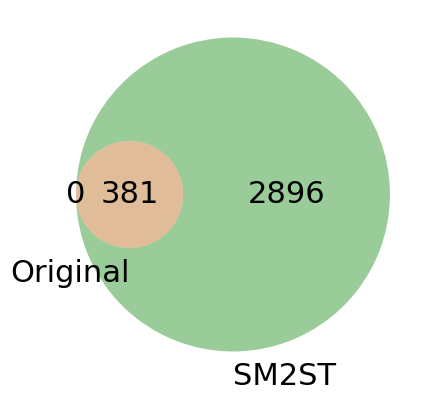

In [48]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# 定义两个集合
set1 = ms_adata_v
set2 = adata_SMLED_v

# 绘制韦恩图
venn = venn2([set1, set2], ('Original', 'SM2ST'))

# 设置标签显示交集和差集的数目
venn.get_label_by_id('100').set_text(f'{len(set1 - set2)}')
venn.get_label_by_id('010').set_text(f'{len(set2 - set1)}')
venn.get_label_by_id('110').set_text(f'{len(set1 & set2)}')
# 设置交集和差集标签的字体大小
venn.get_label_by_id('100').set_fontsize(22)
venn.get_label_by_id('010').set_fontsize(22)
venn.get_label_by_id('110').set_fontsize(22)

# 设置集合标签的字体大小
venn.get_label_by_id('A').set_fontsize(22)  # 设置集合1的标签字体大小
venn.get_label_by_id('B').set_fontsize(22)  # 设置集合2的标签字体大小
# 显示图形
plt.show()

In [49]:
set1 - set2

set()

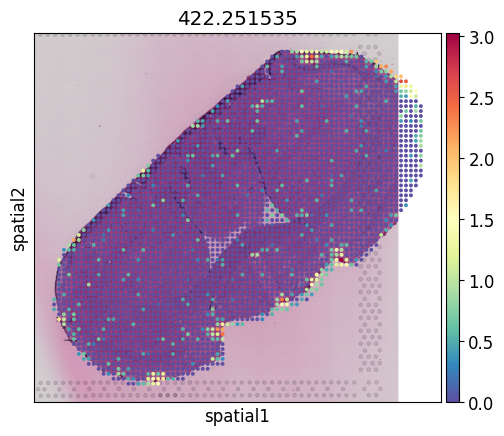

In [50]:
sc.pl.spatial(ms_adata, 
              img_key="hires", 
              color=['422.251535'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

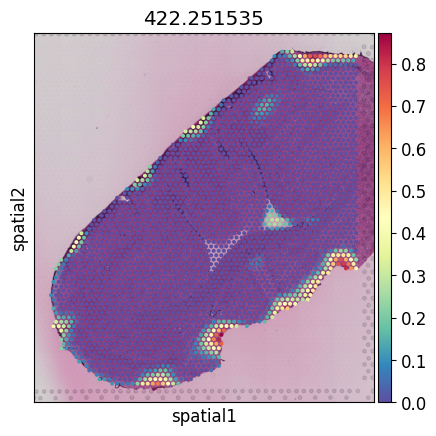

In [51]:
sc.pl.spatial(adata_SMLED, 
              img_key="hires", 
              color=['422.251535'], 
              cmap='Spectral_r', 
              ncols=3,
              img=None, 
              size=0.05,
              spot_size=None,
              bw=False, 
              alpha_img=1)#color是一个感兴趣的基因的list

In [52]:
# ms_adata挑选这些基因set1 & set2
ms_adata_va = ms_adata[:,list(ms_adata_v)]
adata_SMLED_va = adata_SMLED[:,list(ms_adata_v)]

In [53]:
ms_column_sums = np.sum(ms_adata_va.X.A, axis=0)
# 除以行总数（m）
ms_m = ms_adata.X.A.shape[0]
ms_column_means = ms_column_sums / ms_m
SMLED_column_sums = np.sum(adata_SMLED_va.X.A, axis=0)
# 除以行总数（m）
SMLED_m = ms_adata.X.A.shape[0]
SMLED_column_means = SMLED_column_sums / SMLED_m

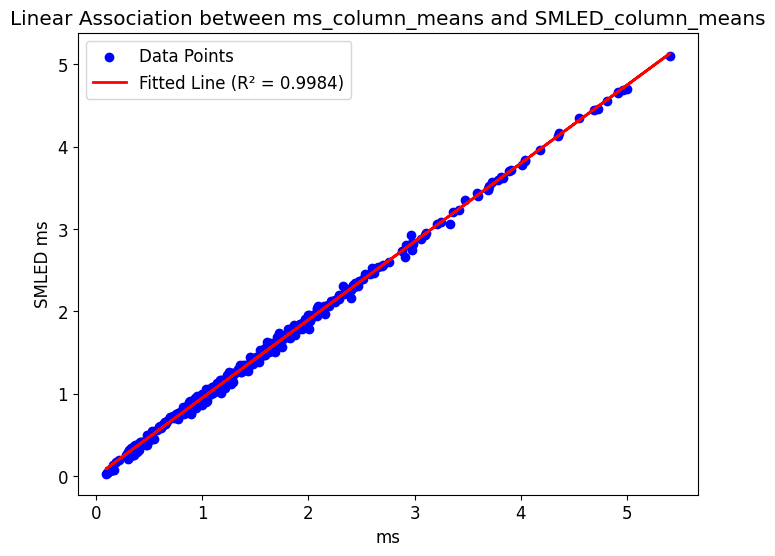

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 假设 ms_column_means 和 SMLED_column_means 是两个 NumPy 数组
# 如果不是 NumPy 数组，可以使用 np.array() 进行转换

# 计算线性回归
X = ms_column_means.reshape(-1, 1)  # 将 ms_column_means 转换为列向量
y = SMLED_column_means

# 创建线性回归模型
model = LinearRegression()
model.fit(X, y)

# 预测值
y_pred = model.predict(X)

# 计算 R² 值
r2 = r2_score(y, y_pred)

# 绘制散点图和拟合曲线
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Data Points')  # 原始数据点
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Fitted Line (R² = {r2:.4f})')  # 拟合曲线
plt.xlabel('ms')
plt.ylabel('SMLED ms')
plt.title('Linear Association between ms_column_means and SMLED_column_means')
plt.legend()
# plt.grid(True)
plt.show()